<a href="https://colab.research.google.com/github/milalanier/netflix-rating-prediction/blob/main/Netflix_rating_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting IMDB Rating of Netflix movies

## Project Overview

The objective of this project is to build a machine learning model that predicts movie ratings for Netflix using available movie metadata. A linear regression model is used to examine whether basic features such as duration, release year, and star count can explain variations in audience ratings.

## Problem Statement

Can a movie's rating be reasonably predicted using basic numerical attributes available in a Netflix dataset?

## Dataset Description

The dataset contains information on Netflix titles, including movie titles, release year, duration, rating, genre, and content certification. For this analysis, only movies were included to ensure consistency in duration measurements. TV shows with season-based durations were excluded.

## Target Variable

The target variable for this project is the movie rating, a continuous numerical value representing audience evaluation of each movie.

## Features Used

The following features were used as predictors in the model:

*   Duration (in minutes)
*   Release year
*   Number of votes
*   Additional numeric metadata available in the dataset

## Approach and Methodology

The project follows a standard machine learning workflow:

1.   Data cleaning and preprocessing
2.   Feature engineering
1.   Exploratory data analysis (EDA)
2.   Model training using linear regression
1.   Model evaluation using regression metrics

## Evaluation Metrics

Model performance is evaluated using:


*   R2 Score
*   Mean Absolute Error (MAE)
*   Root Mean Squared Error (RMSE)



#### **The following sections walk through the complete machine learning pipeline, from raw data to model evaluation and conclusions**.

















### Install Packages

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import joblib
sns.set(style='darkgrid')

### Load Data

In [ ]:
df = pd.read_csv('/content/n_movies.csv')
df.head()



,title,year,certificate,duration,genre,rating,description,stars,votes
0,Cobra Kai,(2018– ),TV-14,30 min,"Action, Comedy, Drama",8.5,Decades after their 1984 All Valley Karate Tou...,"['Ralph Macchio, ', 'William Zabka, ', 'Courtn...","177,031"
1,The Crown,(2016– ),TV-MA,58 min,"Biography, Drama, History",8.7,Follows the political rivalries and romance of...,"['Claire Foy, ', 'Olivia Colman, ', 'Imelda St...","199,885"
2,Better Call Saul,(2015–2022),TV-MA,46 min,"Crime, Drama",8.9,The trials and tribulations of criminal lawyer...,"['Bob Odenkirk, ', 'Rhea Seehorn, ', 'Jonathan...","501,384"
3,Devil in Ohio,(2022),TV-MA,356 min,"Drama, Horror, Mystery",5.9,When a psychiatrist shelters a mysterious cult...,"['Emily Deschanel, ', 'Sam Jaeger, ', 'Gerardo...","9,773"
4,Cyberpunk: Edgerunners,(2022– ),TV-MA,24 min,"Animation, Action, Adventure",8.6,A Street Kid trying to survive in a technology...,"['Zach Aguilar, ', 'Kenichiro Ohashi, ', 'Emi ...","15,413"


### Overview

In [ ]:
print(df.shape)
display(df.info())
display(df.describe(include='all').T)

(8784, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 8784 entries, 0 to 9956
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        8784 non-null   object 
 1   year         8784 non-null   object 
 2   certificate  6381 non-null   object 
 3   duration     7680 non-null   object 
 4   genre        8772 non-null   object 
 5   rating       8784 non-null   float64
 6   description  8784 non-null   object 
 7   stars        8784 non-null   object 
 8   votes        8784 non-null   object 
dtypes: float64(1), object(8)
memory usage: 686.2+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
title,8784,6878,Top Gear,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,8784,456,(2020),652,NaN,NaN,NaN,NaN,NaN,NaN,NaN
certificate,6381,19,TV-MA,2490,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,7680,291,60 min,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genre,8772,546,Comedy,771,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,8784.0,NaN,NaN,NaN,6.764515,1.21484,1.7,6.1,6.9,7.6,9.9
description,8784,8488,Add a Plot,254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stars,8784,7846,[],101,NaN,NaN,NaN,NaN,NaN,NaN,NaN
votes,8784,4862,30,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Clean & Basic Preprocessing

In [ ]:
# Drop duplicates and rows missing

df = df.drop_duplicates()
df = df.dropna(subset=['rating'])

# Quick look

df[['title','genre','year','duration','rating']].head()

,title,genre,year,duration,rating
0,Cobra Kai,"Action, Comedy, Drama",(2018– ),30 min,8.5
1,The Crown,"Biography, Drama, History",(2016– ),58 min,8.7
2,Better Call Saul,"Crime, Drama",(2015–2022),46 min,8.9
3,Devil in Ohio,"Drama, Horror, Mystery",(2022),356 min,5.9
4,Cyberpunk: Edgerunners,"Animation, Action, Adventure",(2022– ),24 min,8.6


### Feature engineering

In [ ]:


# 1) stars_count
df['stars_count'] = df['stars'].fillna('').apply(lambda s: 0 if s== '' else len(str(s).split(',')))

# 2) genre_count
df['genre_count'] = df['genre'].fillna('').apply(lambda s: 0 if s=='' else len(str(s).split(',')))

# 4) drop rows with missing numeric features we need
df = df.dropna(subset=['duration','year','title','rating','genre'])

# 5) strip non-number part of duration_in_mins column
df['duration_in_mins'] = df['duration'].str.replace('min', '').astype(float)

# 6) extract only first 4 digits from a string for 'year' column
df['year'] = df['year'].str.extract('(\d{4})').astype(float)

# final feature set

features = ['duration_in_mins','stars_count','genre_count', 'year']
target = 'rating'
X = df[features]
Y = df[target]
X.head()

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-877961462.py:14: SyntaxWarning: invalid escape sequence '\d'
  df['year'] = df['year'].str.extract('(\d{4})').astype(float)


,duration_in_mins,stars_count,genre_count,year
0,30.0,7,3,2018.0
1,58.0,7,3,2016.0
2,46.0,7,2,2015.0
3,356.0,7,3,2022.0
4,24.0,7,3,2022.0


### Train/test split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Preprocessing + model pipeline

In [ ]:
numeric_features = ['duration_in_mins','stars_count','genre_count','year']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

model.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['duration_in_mins',
                                                   'stars_count', 'genre_count',
                                                   'year'])])),
                ('regressor', Ridge())])

### Evaluation

R2: 0.07765325998912198
MAE: 0.9460822491003184
RMSE: 1.1896512487550581


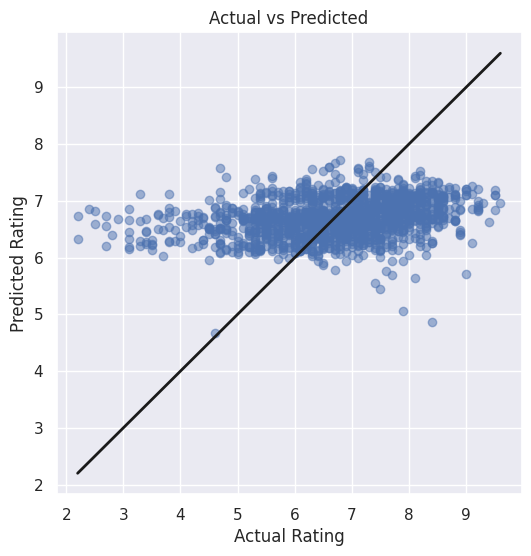

In [ ]:
y_pred = model.predict(X_test)
print("R2:", r2_score(Y_test, y_pred))
print("MAE:", mean_absolute_error(Y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(Y_test, y_pred,)))

# Plot actual v predicted
plt.figure(figsize=(6,6))
plt.scatter(Y_test, y_pred, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=2)
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Actual vs Predicted")
plt.show()

In [ ]:
### Feature importance (coefficients)

In [ ]:
coefs = model.named_steps['regressor'].coef_
print("Coefficients:", dict(zip(numeric_features, coefs)))

Coefficients: {'duration_in_mins': np.float64(-0.16470704655003401), 'stars_count': np.float64(-0.1803734134494117), 'genre_count': np.float64(0.2118320995861746), 'year': np.float64(-0.1205298274893655)}


### Save model

In [ ]:
os.makedirs("../models", exist_ok=True)
joblib.dump(model, "../models/netflix_rating_ridge.joblib")
print("Saved model to models/netflix_rating_ridge.joblib")

Saved model to models/netflix_rating_ridge.joblib


## Conclusions

In this project, a linear regression model was developed to predict Netflix movie ratings using numerical features such as duration, release year, and popularity indicators. The model acheived an R2 score of approximately 0.08, indicating that while some relationships exists between the selected features and ratings, the model explains only a modest portion of the overall variance.

The Actual vs. Predicted plot shows that the model tends to predict values near the mean rating, resulting in overstimation for low rated movies and underestimation for highly rated movies. This suggests that while the model captures general trends in the data, it lacks the complexity required to fully model audience preferences.

Overall, this project demonstrates the complete machine learning workflow, including data cleaning, feature engineering, model training, and evaluation. The results highlight both the strenghts and limitations of linear regression when applied to subjective outcomes such as movie ratings.

## Next steps

Several improvements could be make to enhance model performance. first, additional features such as genre encoding, director popularity, cast popularity, or text-based features extracted from movies descriptions could provide richer predictive signals. Second, more advanced models such as Ridge Regression, or Lasso Regression may better capture nonlinear relationships.

Additionally, separating movies by genre or rating category could reduce noise and improve accuracy. Finally, incorporating natural language processing techniques on movie descriptions could help capture audience sentiment and thematic elements that influence movie ratings.